<a href="https://colab.research.google.com/github/gubruschi/labs-sistemas-inteligentes/blob/main/Ataques_DDOS_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Integrantes



Guilherme Damasceno, Gustavo B. Antunes, Gustavo K. Fujissaka, Gustavo K. Sumita, Lucas C. Batista

`{guilherme.damasceno,g.bruschi,gustavo.fujissaka,g.sumita,lucas.chaves}@aluno.ufabc.edu.br`


# Problema de Classificação

O objetivo deste trabalho é aplicar um classificador de árvore aleatória em um conjunto de dados fornecido pelo Instituto de Cibersegurança Canadense (CIC) da Universidade de New Brunswick (UNB). Esse conjunto contém informações detalhadas sobre fluxos de rede como protocolo, duração do fluxo e número total de pacotes enviados. A proposta é usar essas informações para treinar um Random Forest Classifier e aplicar em um Sistema de Detecção de Intrusão (IDS), tornando-o capaz de classificar o tráfego de rede como legítimo ou como um ataque DDoS.

# Sobre o dataset

O dataset CICDDoS2019 é um conjunto de dados criado pelo Canadian Institute for Cybersecurity (CIC) com foco na detecção de ataques DDoS (Distributed Denial-of-Service). Ele contém dados simulados de tráfego de rede para diferentes tipos de ataques DDoS, como UDP Flood, SYN Flood e outros. As amostras são categorizadas como tráfego normal ou malicioso, e os recursos incluem estatísticas de pacotes, taxas de transmissão e padrões temporais.

# Importando bibliotecas necessárias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Carregando Dataset

Foi feito, previamente, o upload do dataset nos arquivos do colab.

In [ ]:
df = pd.read_csv("cicddos2019_dataset.csv")
df

,Unnamed: 0,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Class
0,0,17,216631,6,0,2088.0,0.0,393.0,321.0,348.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack
1,1,17,2,2,0,802.0,0.0,401.0,401.0,401.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack
2,2,17,48,2,0,766.0,0.0,383.0,383.0,383.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack
3,3,17,107319,4,0,1398.0,0.0,369.0,330.0,349.50000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack
4,4,17,107271,4,0,1438.0,0.0,389.0,330.0,359.50000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431366,306196,6,550740,2,1,0.0,31.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign
431367,306197,6,337766,1,3,31.0,62.0,31.0,31.0,31.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign
431368,306198,6,228,1,2,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign
431369,306199,17,47709,2,2,86.0,194.0,43.0,43.0,43.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign


## Visualização dos dados

As colunas do dataset possuem métricas detalhadas do tráfego de rede, utilizadas para detectar padrões normais ou maliciosos. Elas incluem:

* Protocolo e Fluxo: Informações básicas como o protocolo usado (TCP/UDP) e a duração do fluxo.
* Contagem e Tamanho dos Pacotes: Total de pacotes enviados e recebidos, seus tamanhos máximos, mínimos, médios e desvios padrões.
* Taxas e Intervalos de Tempo: Métricas de bytes/pacotes por segundo e tempos entre pacotes no fluxo (IAT - Inter Arrival Time).
* Sinais de Controle: Presença de flags como FIN, SYN, ACK e PSH nos pacotes, indicando estados específicos da conexão.
* Atributos Agregados: Subfluxos, tamanhos médios de pacotes e segmentos, e relação entre tráfego de entrada e saída (Down/Up Ratio).
* Janelas e Atividade: Estatísticas de janelas iniciais e padrões de atividade/ociosidade.

Os dados já categorizados estão nas colunas `Class` e `Label`.

Na coluna `class`, temos a categorização de se é um ataque ou não (`Attack` e `Benign`)
Na coluna `Label`, temos o tiṕo de tráfego, que pode ser normal (como um tráfego UDP) ou um ataque (descritos com DrDoS)

In [ ]:
print("Tipos de Tráfego:")

for item in df["Label"].unique():
    print("-", item)

Tipos de Tráfego:
- UDP
- MSSQL
- Benign
- Portmap
- Syn
- NetBIOS
- UDPLag
- LDAP
- DrDoS_DNS
- UDP-lag
- WebDDoS
- TFTP
- DrDoS_UDP
- DrDoS_SNMP
- DrDoS_NetBIOS
- DrDoS_LDAP
- DrDoS_MSSQL
- DrDoS_NTP


Gráficamente podemos ver a distribuição das classes, sendo notável que há mais de um tipo, ou seja, há classes desbalanceadas.

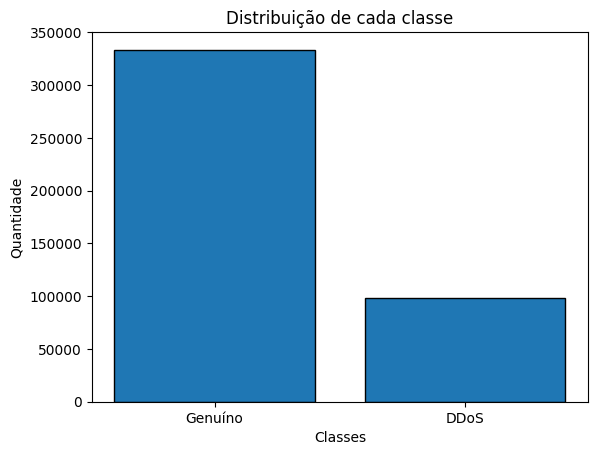

In [ ]:
plt.bar(["Benign", "Attack"], df['Class'].value_counts(), edgecolor='black')
plt.xticks(["Benign", "Attack"], labels=['Genuíno', 'DDoS'])
plt.xlabel('Classes')
plt.ylabel('Quantidade')
plt.title('Distribuição de cada classe')
plt.show()

# Treino Random Forest

O Random Forest Classifier é um modelo de classificação baseado em múltiplas árvores de decisão, combinando suas previsões para melhorar a precisão e reduzir overfitting. Os principais parâmetros desse modelo são:
* `n_estimators`: nº de árvores
* `max_depth`: profundidade máxima
* `min_samples_split`: mínimo para dividir
* `min_samples_leaf`: mínimo de folhas

Definiremos, no entanto, somente o n de árvores, deixando os outros parametros como padrão.

O Random Forest é eficaz em problemas de classificação desbalanceados porque, ao ser um ensemble de árvores, ele combina o voto de várias árvores, reduzindo o viés para a classe majoritária.

## Separação dos dados

Usaremos o train test split para separar os dados, com 30% deles sendo usados no teste.

In [ ]:
X = df.drop(['Class', "Label"], axis=1) # Dados que usaremos
y = df['Class'] # As classes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True)

print("Tamanho do conjunto de treino =", X_train.shape)
print("Tamanho do conjunto de teste  =", X_test.shape)

Tamanho do conjunto de treino = (301959, 78)
Tamanho do conjunto de teste  = (129412, 78)


## Treino

Uma observação sobre o treino é que quanto maior o `n_estimators`, mais demorado é. <br>
Com 50, o tempo computacional aqui é de aproximadamente 40 segundos;<br>
Com 100, o tempo sobre para 1 minuto.


In [ ]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Resultados

Iremos analisar a precisão do random forest com as métricas de A**ccuracy, F1 Score, Precision e Recall**, pois em problemas de classificação com classes desbalanceadas, precisão e recall são importante para entender a exatidão das previsões positivas e a capacidade de identificar todas as instâncias positivas.
<br> E o F1-score combina ambas, equilibrando o desempenho do modelo.

In [ ]:
print('Métricas para Random Forest:')
print("Accuracy: %.4f" % accuracy_score(y_test, rf_pred))
print("F1 Score: %.4f" % f1_score(y_test, rf_pred, average='binary', pos_label="Attack"))
print("Precision: %.4f" % precision_score(y_test, rf_pred, average='binary', pos_label="Attack"))
print("Recall: %.4f" % recall_score(y_test, rf_pred, average='binary', pos_label="Attack"))

Métricas para Random Forest:
Accuracy: 0.9996
F1 Score: 0.9998
Precision: 0.9999
Recall: 0.9996


Vamos ver também como foi o resultado da classificação através das matrizes de confusão

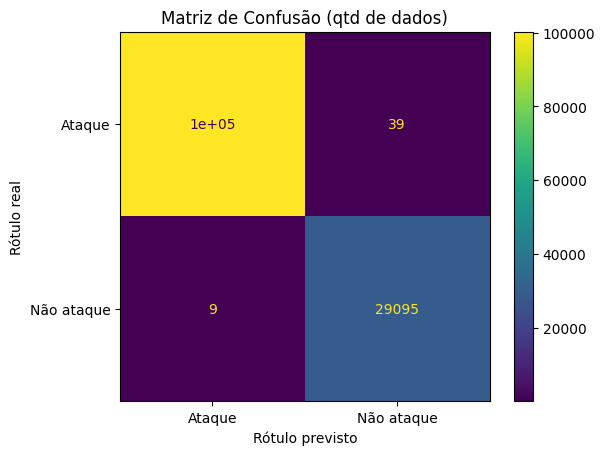

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, rf_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Ataque", "Não ataque"])
cm_display.plot()
plt.xlabel("Rótulo previsto")
plt.ylabel("Rótulo real")
plt.title("Matriz de Confusão (qtd de dados)")
plt.show()

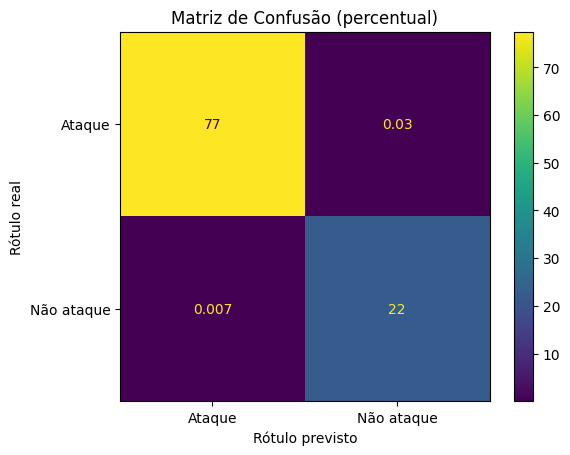

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, rf_pred)
confusion_matrix_percent = confusion_matrix.astype('float') / confusion_matrix.sum() * 100

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_percent, display_labels = ["Ataque", "Não ataque"])
cm_display.plot()

plt.xlabel("Rótulo previsto")
plt.ylabel("Rótulo real")
plt.title("Matriz de Confusão (percentual)")
plt.show()


Um ponto relevante na analise dos resultados, pensando no problema de classificação, é entender quais caracteristicas (features) dos dados são mais importantes para o classificador. Isso conseguimos ver através do gráfico abaixo.

Esse grafico lista todas features analisadas no treino do classificador mostra quais delas tiveram um certo grau de importancia.

Para o nosso problema em especifico, vemos que para a detecção de ataques de negação de serviço, o tamanho minimo de pacotes em FORWARD é uma das caracteristicas mais relevantes. Isso se deve ao fato de que esses ataques enviam muitos pacotes para o seu alvo, que quando passam por um roteador que tem um detector, é visto como forward.

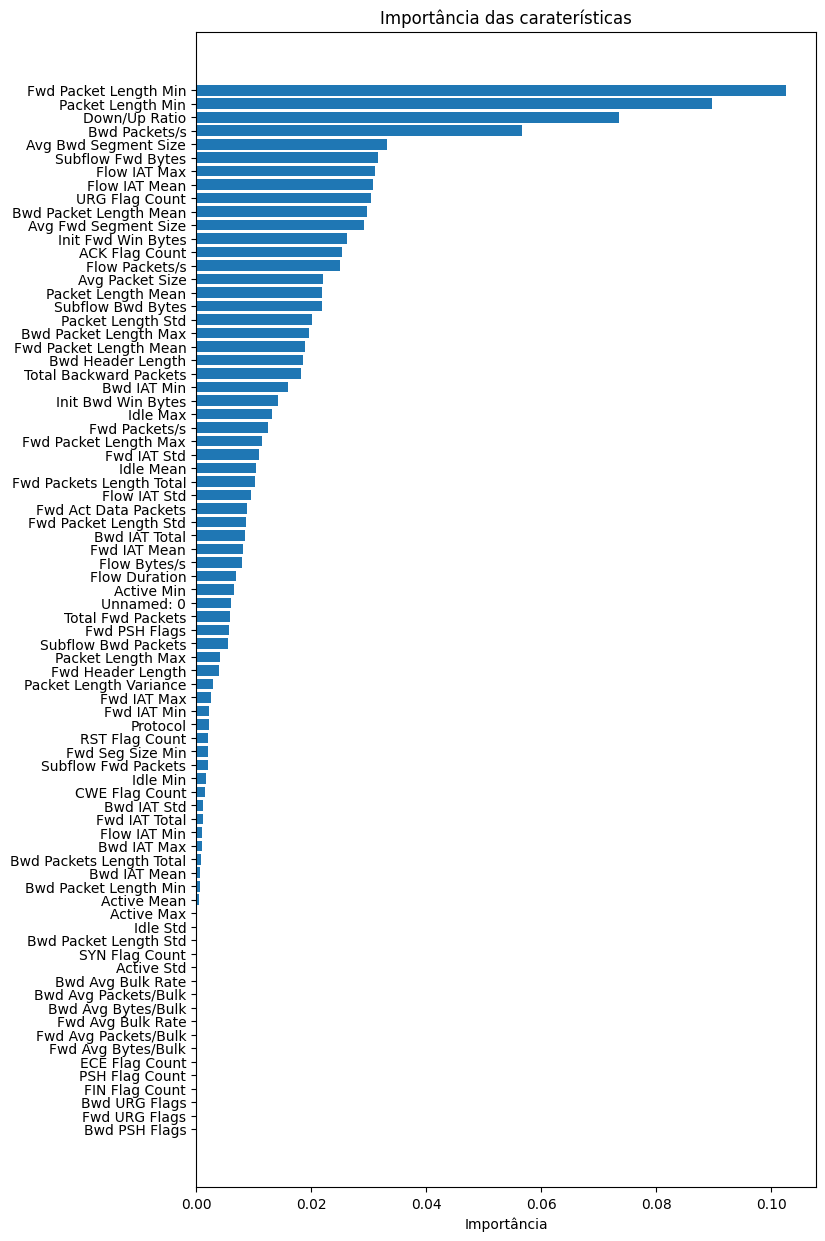

In [ ]:
importances = rf_model.feature_importances_

indices = sorted(range(len(importances)), key=lambda i:
importances[i], reverse=False)
feature_names = X_train.columns[indices]

plt.figure(figsize=(8, 15))
plt.barh(range(X_train.shape[1]), importances[indices], align="center")
plt.yticks(range(X_train.shape[1]), feature_names)
plt.xlabel("Importância")
plt.title("Importância das caraterísticas")
plt.show()

#Conclusões

De maneira geral, com base nas métricas de desempenho do classificador, podemos concluir que o algoritmo Random Forest é bastante eficaz na identificação de ataques DDoS e tráfego legítimo em redes. No entanto, observamos que o modelo cometeu alguns erros, embora em pequena proporção, ao classificar ataques como tráfego legítimo. Esse tipo de erro pode ser mais problemático do que o inverso, ou seja, classificar tráfego legítimo como ataque. Isso pode ser atribuído ao fato de que o treinamento do modelo foi afetado por um viés, já que os dados utilizados não estavam balanceados.

#Referências

Sharafaldin, I., Lashkari, A. H., & Ghorbani, A. A. (2019). "Developing Realistic Distributed Denial of Service (DDoS) Attack Dataset and Taxonomy".

Canadian Institute for Cybersecurity (CIC) (2019). "Distributed Denial of Service (DDoS) 2019 Dataset". University of New Brunswick. Disponível em: https://www.unb.ca/cic/datasets/ddos-2019.html.                                                     Acesso em: 10 de dezembro de 2024.

Equipe scikit-learn (2024). "RandomForestClassifier". scikit-learn: Machine Learning in Python. Disponível em: https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html. Acesso em: 10 de dezembro de 2024
